In [41]:
import time
import csv
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from collections import deque
from threading import Lock

import myo
import numpy as np

In [42]:



class EmgCollector(myo.DeviceListener):
    def __init__(self, n):
        self.n = n
        self.lock = Lock()
        self.emg_data_queue = deque(maxlen=n)

    def get_emg_data(self):
        with self.lock:
            return list(self.emg_data_queue)

    def on_connected(self, event):
        event.device.stream_emg(True)

    def on_emg(self, event):
        with self.lock:
            self.emg_data_queue.append((event.timestamp, event.emg))


class Plot:
    def __init__(self, listener):
        self.n = listener.n
        self.listener = listener
        self.colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'purple']

        self.fig, self.axes = plt.subplots(8, 1, figsize=(10, 12), sharex=True)
        for ax in self.axes:
            ax.set_ylim([-100, 100])
            ax.set_ylabel("EMG")
            ax.grid(True)
        self.graphs = [
            ax.plot(np.arange(self.n), np.zeros(self.n), color=color)[0]
            for ax, color in zip(self.axes, self.colors)
        ]
        self.fig.tight_layout()

        self.start_time = None  # para controlar 10 segundos

    def update_plot(self, frame):
        if self.start_time is None:
            self.start_time = time.time()

        elapsed = time.time() - self.start_time
        if elapsed > 10:  # interrompe após 10 segundos
            plt.close(self.fig)
            return self.graphs

        emg_data = self.listener.get_emg_data()
        if not emg_data:
            return self.graphs
        emg_data = np.array([x[1] for x in emg_data]).T
        for g, data in zip(self.graphs, emg_data):
            if len(data) < self.n:
                data = np.concatenate([np.zeros(self.n - len(data)), data])
            g.set_ydata(data)
        return self.graphs

    def main(self,save_name):
        ani = FuncAnimation(self.fig, self.update_plot, interval=33, blit=False)
        plt.show()

        # Salvar dados em CSV após fechar a janela
        emg_data = self.listener.get_emg_data()
        with open(f"{save_name}.csv", "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["Timestamp"] + [f"Channel{i+1}" for i in range(8)])
            for row in emg_data:
                writer.writerow([row[0]] + list(row[1]))
        print(f"Dados salvos em {save_name}.csv")




C:\Users\jose23038\AppData\Local\Temp\ipykernel_24864\1348435234.py:58: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(self.fig, self.update_plot, interval=33, blit=False)


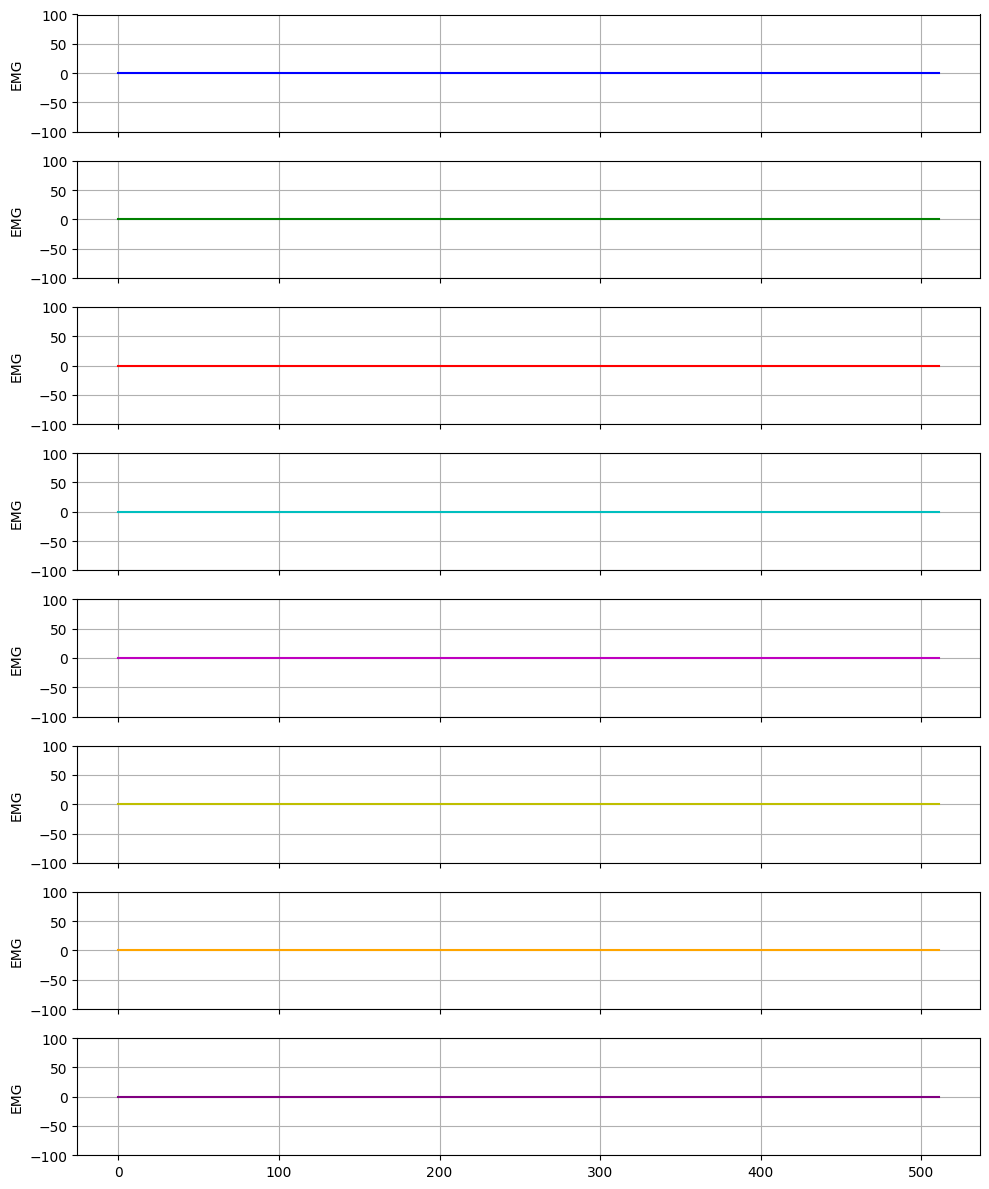

Dados salvos em polegar.csv


In [43]:

def main():
    myo.init()
    hub = myo.Hub()
    listener = EmgCollector(512)
    with hub.run_in_background(listener.on_event):
        Plot(listener).main("polegar")


if __name__ == '__main__':
    main()